<a href="https://colab.research.google.com/github/MatthewChiu/Chord_spacing_and_quality/blob/main/Chord_Spacing_and_Quality_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Tools For Computation and Plotting

Here's the bulk of our methodological code, where we define the mechanisms of computing DFTs and plotting their components. These serve as the basis for the figures below, as included in our presentation.

In [ ]:
from music21 import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# input: list of Music21 pitches
# output: char funcs in both PC (pitch-class numbers) and MIDI (pitch)
# normalized to account for variance in cardinality
# (that is, list should sum to 1)
# ie C, C# = [0,1] -> [0.5,0.5,0,0,0,0,0,0,0,0,0,0] for PC
def characteristicFunction(collection):
  normalizer = 1 / len(collection)
  PCBin = 12 * [0]
  for i in [p.pitchClass for p in collection]:
    PCBin[i] += normalizer
  MidiBin = 256 * [0]
  for i in [p.midi for p in collection]:
    MidiBin[i] += normalizer
  return PCBin, MidiBin

# input: array of characteristic functions
# output: array of DFT Magnitude arrays
def DFTCalculationForArrays(arrayOfChords):
  magsPC = [np.absolute(np.fft.fft(cfs[0])) for cfs in arrayOfChords]
  magsMidi = [np.absolute(np.fft.fft(cfs[1])) for cfs in arrayOfChords]
  return magsPC, magsMidi

# Euclidean Distance between any two arrays (such as DFT Outputs)
# essentially |array1 - array2|
# input: two arrays. output: a real number of their distance
def euclideanDistance(array1, array2):
  return np.linalg.norm([array1[i] - array2[i] for i in range(len(array1))])

# given DFT calculations for at least one chord,
# plot both P- and PC-DFTs on separate plots
# input: output of DFTCalculationForArrays, in form
# no output retured, but plots appear with plt.show()
# (PC-DFT magnitudes for each chord, P-DFT magnitudes for each chord)
def allIndivPlots(DFTCalculationForAllChords, labels=[]):
  magnitudeForPCDFT, magnitudeForMidiDFT = DFTCalculationForAllChords

  plt.figure()
  plt.title('P-DFT')
  for i in magnitudeForMidiDFT:
    plt.plot(i[0:129]) # ignore Nyquist components
  plt.legend(labels)
  plt.xlabel('component')
  plt.ylabel('magnitude')

  plt.figure()
  plt.title('PC-DFT')
  for i in magnitudeForPCDFT:
    plt.plot(i[0:7])
  plt.legend(labels)
  plt.xlabel('component')
  plt.ylabel('magnitude')

# DFTs on the Cathedral Chord

Here, we introduce the "Cathedral Chord" (opening chord of "Sunken Cathedral"), calculate its PC- and P-DFTs, and plot them separately, all using utilities defined above.

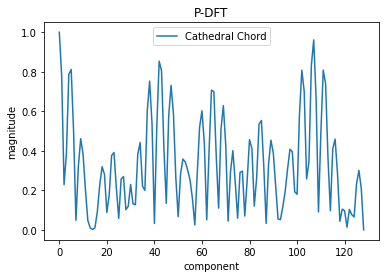

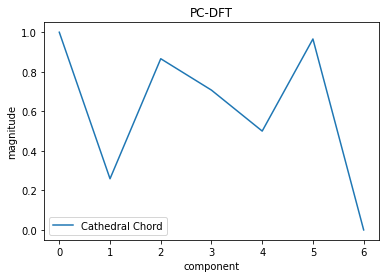

In [ ]:
cathChord = chord.Chord(['G1', 'D2', 'G2', 'D6', 'G6', 'D7'])
cathDFT = DFTCalculationForArrays([characteristicFunction(cathChord.pitches)])
allIndivPlots(cathDFT, ['Cathedral Chord'])
plt.show()

# 2,000 Random Chords

The following code generates 2,000 random chords (2–6 notes each, all from the range of a piano) and plots them based on their Euclidean distances in terms of both P- and PC-DFT to the Cathedral Chord. It also identifies the two chords on which the two Euclidean distances vary the least—that is, where P- and PC-DFT diverge the most.

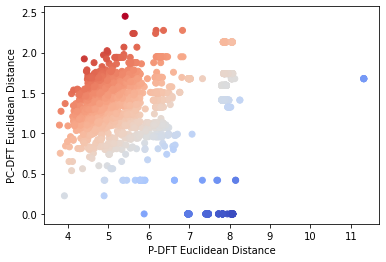

similar by PC but far by P: [B3, E5]
similar by P but far by PC: [D1, E1, C4, G#4, B-4, F#7]


In [ ]:
import random, math

# number of random chords to generate
howmany = 2000

# noting relevant DFTs for Cathedral Chord
chordPCDFT, chordMidiDFT = [cathDFT[i][0] for i in range(2)]

# here are the random chords
allChords = [[pitch.Pitch(midi=random.randint(21,108))
    for j in range(random.randint(2,6))]
  for i in range(howmany)]

# calculate their DFTs
listOfCFs = [characteristicFunction(i) for i in allChords]
pcMags, midiMags = DFTCalculationForArrays(listOfCFs)

# calculate their Euclidean distances relative to Cathedral Chord
midiEuclid = [euclideanDistance(chordMidiDFT, i) for i in midiMags]
PCEuclid = [euclideanDistance(chordPCDFT, i) for i in pcMags]

# to identify outliers from a trend of perfect correlation,
# we need the distance from a point to a line
# inputs: x and y coordinates of point, m slope and c y-intercept of line
# output: distance of point from line
def distpointline(x, y, m, c):
  num = (-m)*x + y + c
  den = math.sqrt(m*m + 1)
  return num/den

# dissimilarities: given the two data sets (ie P- and PC- Euclids),
# calculate how far each one is from our theoretical ideal correlation
# inputs: the two lists of distances (same objects, different measures)
# note that "ideal correlation" is just a line through the extreme points
# outputs: how far each distance-pair is from line of best fit
def dissimilarities(m1, m2):
  bestfit = np.polyfit([min(m1), max(m1)], [min(m2), max(m2)], 1)
  return [distpointline(m1[i], m2[i], bestfit[0], bestfit[1])
    for i in range(min(len(m1), len(m2)))]

thisdissim = dissimilarities(midiEuclid, PCEuclid)

# plot MIDI vs PC
plt.figure()
plt.scatter(midiEuclid, PCEuclid, c=thisdissim, cmap='coolwarm')
plt.xlabel('P-DFT Euclidean Distance')
plt.ylabel('PC-DFT Euclidean Distance')
plt.show()

# and tell us the two "outliers" to look at:

closePC = sorted(allChords[np.argmin(thisdissim)])
closeP  = sorted(allChords[np.argmax(thisdissim)])

for i in [(closePC, 'PC', 'P'), (closeP, 'P', 'PC')]:
  print('similar by', i[1], 'but far by', i[2]+':', '[', end='')
  for j in i[0][0:-1]:
    print(j, end=', ')
  print(i[0][-1], ']', sep='')

## P–PC DFT divergences

And just like in the presentation, we want to compare PC- and P-DFTs, for the Cathedral Chord as well as the two chords that specifically are close to the Cathedral Chord by only one of the two metrics.

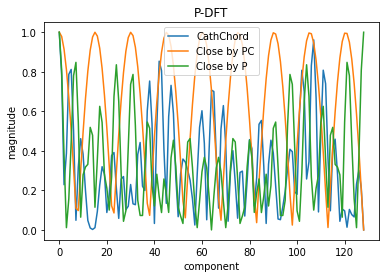

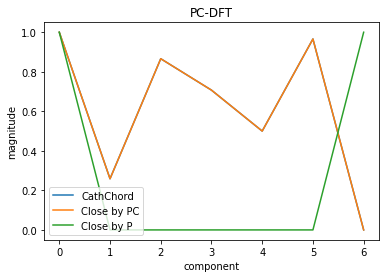

In [ ]:
threePitchLists = [cathChord.pitches, closePC, closeP]
threeCFs = [characteristicFunction(i) for i in threePitchLists]
threeDFTs = DFTCalculationForArrays(threeCFs)
threelabels = ['CathChord', 'Close by PC', 'Close by P']
allIndivPlots(threeDFTs, threelabels)

# three chords from *Verblendungen*

Our talk concluded with P-DFT plots for 3 chords from Kaija Saariaho's *Verblendungen*; here is an implementation where all of those plots are overlaid.

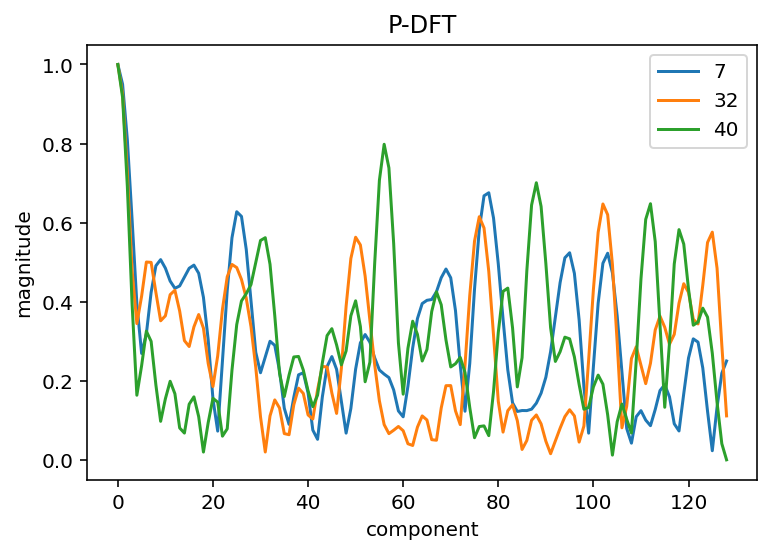

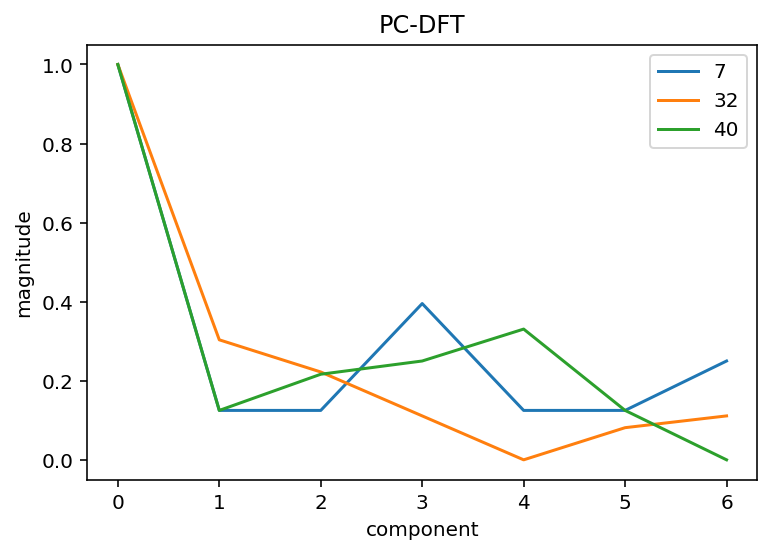

In [ ]:
# the three chords
chord7 = ['E1', 'D2', 'F2', 'A3', 'B-3', 'C4', 'C#4', 'G#4']
chord32 = ['E1', 'D2', 'C3', 'B-3', 'G#4', 'A4', 'B4', 'Db5', 'Eb5']
chord40 = ['E1', 'C#2', 'A#2', 'G3', 'Eb4', 'A4', 'D5', 'F#5']

# the three chords
chordDict = {
  '7': chord.Chord(chord7), '32': chord.Chord(chord32), '40': chord.Chord(chord40),
}

chordKeys = list(chordDict.keys())
chordList = [chordDict[i] for i in chordKeys]

ListOfCFs = [characteristicFunction(i.pitches) for i in chordList]
allIndivPlots(DFTCalculationForArrays(ListOfCFs), chordKeys)
plt.show()